In [123]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import *
from dots.models import MLP, DeepLinear
from dots.dots import *
from dots.utils import get_device, entropy, plot_dots_stats, random_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep linear models


In [132]:
deep_linear = DeepLinear(1, 1, hidden=5, hidden_size=10, bias=False)
deep_linear.count_params()

420

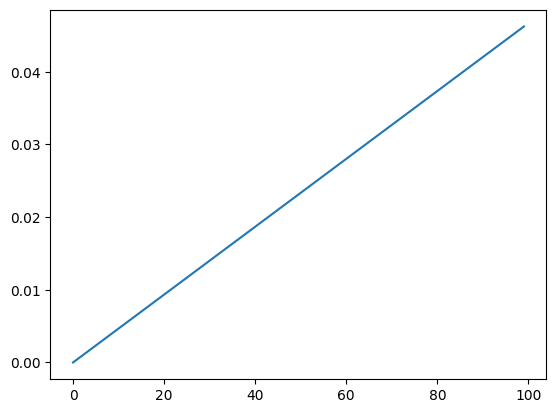

In [133]:
plt.plot(deep_linear(t.linspace(0, 5, 100).unsqueeze(-1)).detach().numpy())

In [134]:
deep_linear.matrix_jacobian(random_batch(10, 1)).shape

torch.Size([10, 420])

Jacobian rank ranks: [tensor(1), tensor(1), tensor(1)]
SV rank, entropy ranks: [tensor(1.0000), tensor(1.0001), tensor(1.0004)]
SV rank, heuristic threshold ranks: [1, 1, 1]
Maximum rank ranks: [10, 100, 420]
Parameters in model: 420


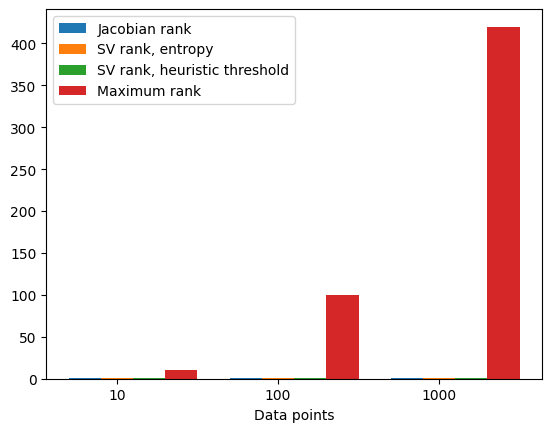

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax2.hist(importances, bins=100, log=True)
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


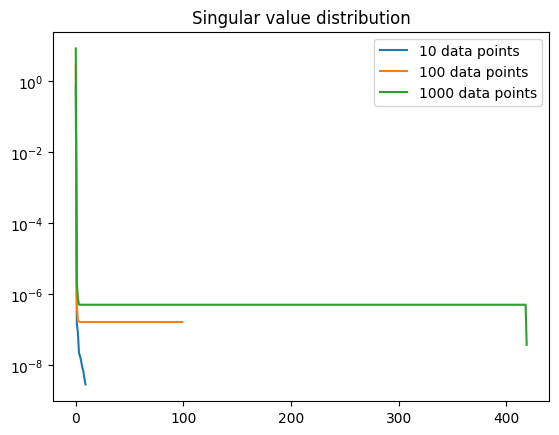

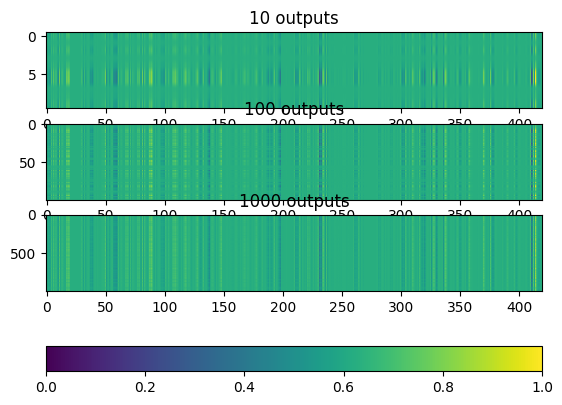

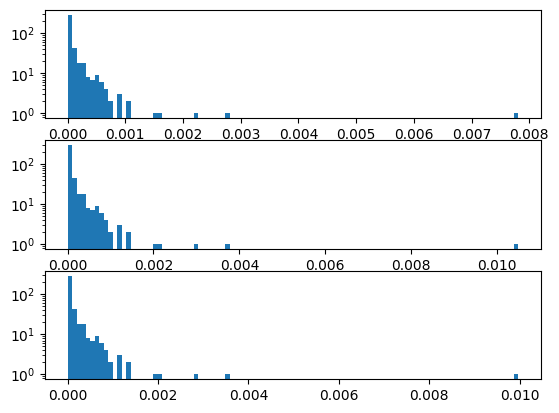

In [135]:
plot_dots_stats(
    deep_linear,
    [
        random_batch(10, 1),
        random_batch(100, 1),
        random_batch(1000, 1)
    ]
)

Jacobian rank ranks: [tensor(5), tensor(5), tensor(5)]
SV rank, entropy ranks: [tensor(1.7173), tensor(1.8049), tensor(1.8131)]
SV rank, heuristic threshold ranks: [1, 1, 1]
Maximum rank ranks: [40, 400, 501]
Parameters in model: 501


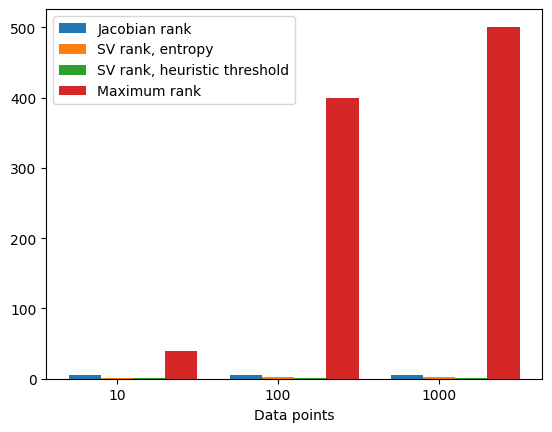

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax2.hist(importances, bins=100, log=True)
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


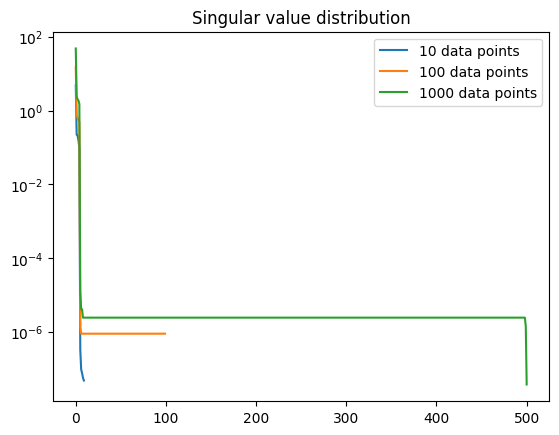

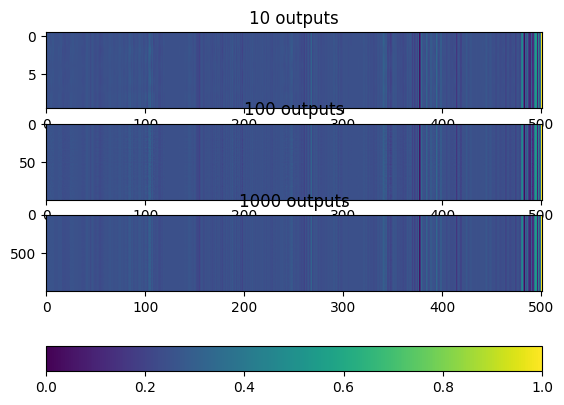

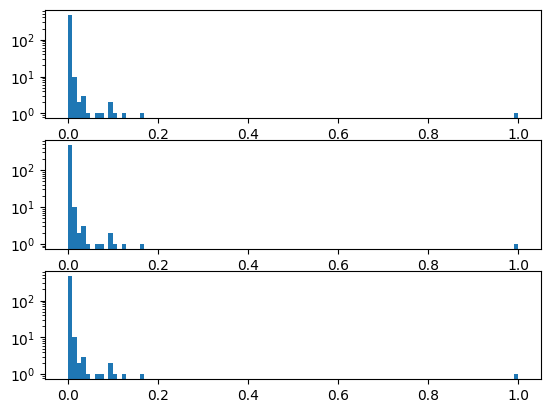

In [136]:
deep_linear2 = DeepLinear(4, 1, hidden=5, hidden_size=10)

plot_dots_stats(
    deep_linear2,
    [
        random_batch(10, 4),
        random_batch(100, 4),
        random_batch(1000, 4)
    ]
)

Jacobian rank ranks: [tensor(6), tensor(6), tensor(6)]
SV rank, entropy ranks: [tensor(2.8466), tensor(3.0156), tensor(3.0222)]
SV rank, heuristic threshold ranks: [2, 2, 2]
Maximum rank ranks: [20, 200, 492]
Parameters in model: 492


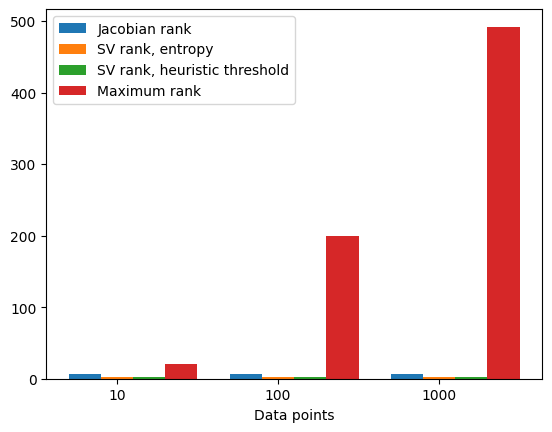

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax2.hist(importances, bins=100, log=True)
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


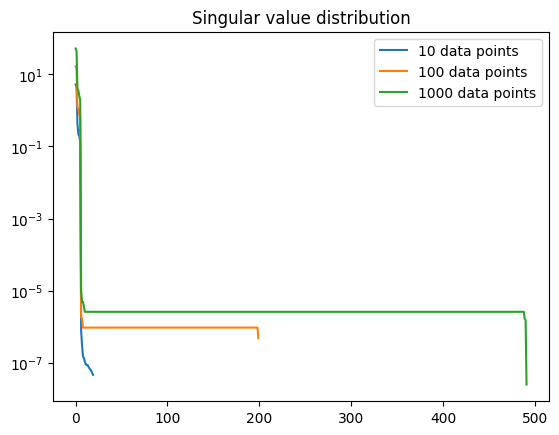

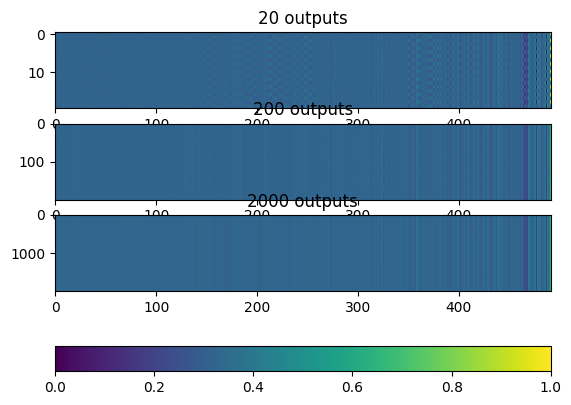

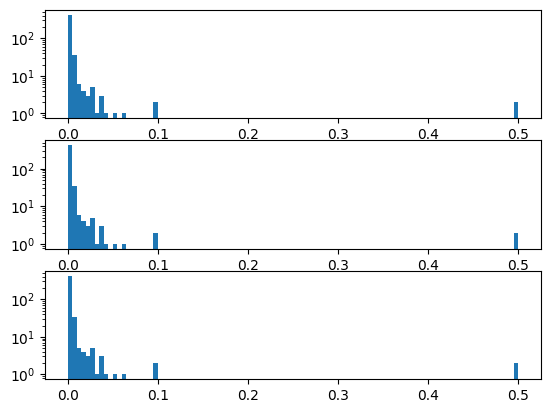

In [137]:
deep_linear3 = DeepLinear(2, 2, hidden=5, hidden_size=10)

plot_dots_stats(
    deep_linear3,
    [
        random_batch(10, 2),
        random_batch(100, 2),
        random_batch(1000, 2)
    ]
)